In [3]:
import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import scipy as sp
import multiprocessing as mp
from p_tqdm import p_map
from tqdm import tqdm

In [15]:
from scipy import io
signals = sp.io.loadmat("Received.mat")['RecSig']
signals

array([[ 6.51003101e-04,  9.13883605e-04,  1.15429836e-03, ...,
         2.61508095e-04,  8.05674067e-05, -1.02341002e-04],
       [ 1.04825081e-03,  1.03742441e-03,  1.00105624e-03, ...,
        -6.59202228e-04, -6.89464315e-04, -7.02749070e-04],
       [-7.02983143e-04, -7.86014395e-04, -8.49699823e-04, ...,
         1.45744034e-04,  2.30896757e-04,  3.10352700e-04],
       ...,
       [ 9.19963541e-04,  6.32305952e-04,  3.29027824e-04, ...,
        -7.37267316e-04, -6.06041289e-04, -4.59910781e-04],
       [-7.72478283e-04, -6.71700561e-04, -5.54369770e-04, ...,
         1.00770317e-03,  9.99271280e-04,  9.66234642e-04],
       [-2.55301754e-04, -2.67618011e-04, -2.73346674e-04, ...,
         5.65598764e-04,  6.27873723e-04,  6.74677667e-04]])

<IPython.core.display.Javascript object>


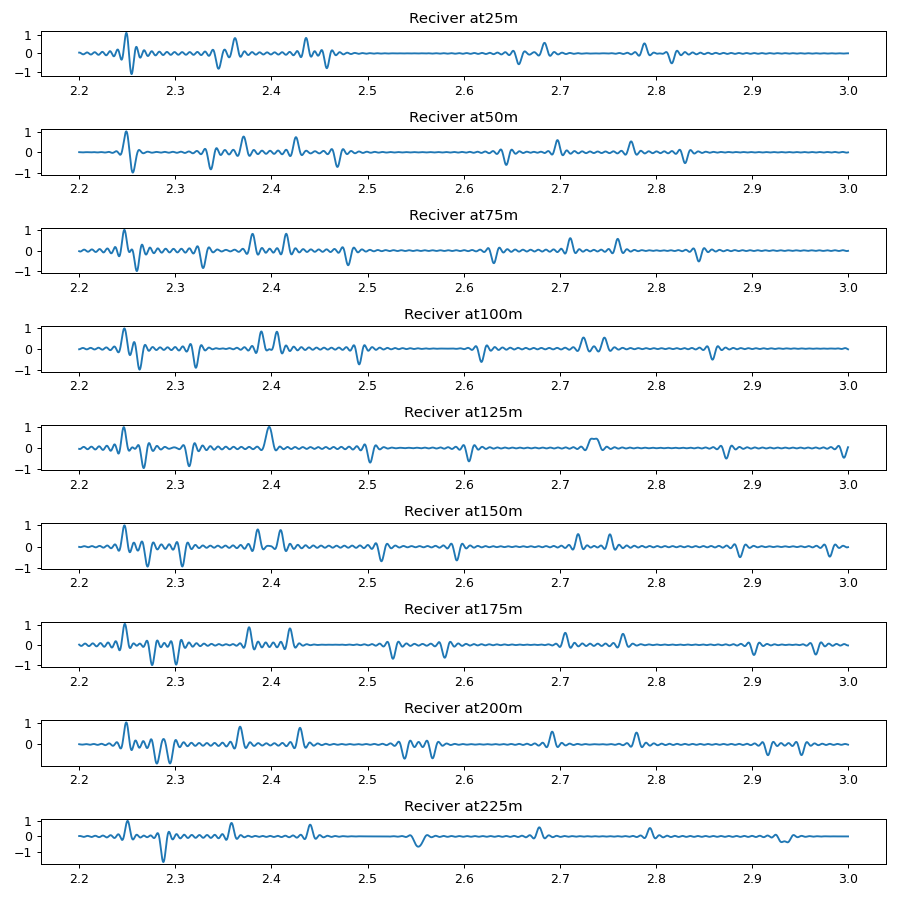

In [28]:
B=200
max_depth = 350
x_0 = 20
z_0 = 100
C_0 = 1500

#Dirac function aproximation
def S(t): 
    x = np.pi*B*t
    exp= np.exp(-B*np.abs(t)/2)
    return exp*np.sin(x)/x

## Green's function * S (convoluted with s)
def G(x,z,x_s,z_s,t):
    
    js = np.arange(-15,15)
    
    g_values = []
    for j in js:
        if j%2 == 0:
            e_j = 1
            r_j = np.sqrt((x-x_s)**2 + (z-z_s + j*max_depth)**2)
        else:
            e_j = -1
            r_j = np.sqrt((x-x_s)**2 + (z+z_s - (j+1)*max_depth)**2)
        
        #print(r_j/C_0)
        sinc_input = t-r_j/C_0
        sinc = S(sinc_input)
        
        g_i= e_j*sinc/(4*np.pi*r_j)
        g_values.append(g_i)
    
    g = np.sum(g_values)
    return -g


def G_signal(x,z,x_s,z_s,t,signal,t_0,dt):
    
    js = np.arange(-15,15)
    
    g_values = []
    for j in js:
        if j%2 == 0:
            e_j = 1
            r_j = np.sqrt((x-x_s)**2 + (z-z_s + j*max_depth)**2)
        else:
            e_j = -1
            r_j = np.sqrt((x-x_s)**2 + (z+z_s - (j+1)*max_depth)**2)
        
        time = t-r_j/C_0
        time_idx = int((time-t_0)//dt) % len(signal)
        
        s_i = signal[time_idx]
        
        g_i = e_j*(s_i/(4*np.pi*r_j))
        g_values.append(g_i)
    
    g = np.sum(g_values)
    return -g

G_signal_v = np.vectorize(G_signal, excluded=[5])


dt = 2e-4
t_0 = 0
t_n = 6.4
time_length = t_n - t_0
t_original = np.arange(t_0,t_n,dt)

#signals_cut = signals[:,11000:15000]
#t_cut = t_original[11000:15000]

signals_cut = signals
t_cut = t_original


x = 1020
z = 200



fig,ax = plt.subplots(9,1,figsize=(10,10))
for i,signal in enumerate(signals_cut):
    ax[i].plot(t_cut,signal)
    ax[i].set_title(f"Reciver at{(i+1)*25} m")
fig.show()
plt.tight_layout()

In [27]:
#Multiple recivers with green propagation
#Supossed Transmitter position
x_0 = 970
z_0 = 115

#Vectorize Green's function
G_vectorized = np.vectorize(G)
x_reciver=0
recivers_z = [i*25 for i in range(1,10)]

#cut signals 
signals_cut = signals[:,10000:25000]
t_cut = t_original[10000:25000]
t_0 = t_original[10000]

    
print("Flipping signals...")
flip_signals = [np.flip(g_i) for g_i in signals_cut]

#Scan for the transmitter in a grid

grid_extend = 100
scan_resolution = 5
transmitter_xs = np.arange(x_0-grid_extend,x_0+grid_extend,scan_resolution)
transmitter_zs = np.arange(z_0-grid_extend,z_0+grid_extend,scan_resolution)
#transmitter_zs = [90,100,110,125]#np.arange(z_0-grid_extend,z_0+grid_extend,scan_resolution)

grid_size = np.ceil((grid_extend*2)/scan_resolution).astype(int)

#set of all posible locations  o.o

locations = np.array(np.meshgrid(transmitter_xs, transmitter_zs)).T.reshape(-1, 2)

print(f"Scanning for posible recivers on a {grid_size}x{grid_size}grid")
#Paralel loop
def localization_loop(position):
        
    xt_i =  position[0]
    zt_i = position[1]
    #print(zt_i,"-",xt_i)
    #calculate new greens  
    filters = [
        G_signal_v(
            xt_i,zt_i, #to
            x_reciver,z_reciver, #from
            t_cut,inv_sig,t_0,dt #time and signal
        )
        for z_reciver,inv_sig in zip(recivers_z,flip_signals)
    ]    
    
    filter_sum = np.sum(filters,axis=0)
    energy = np.sum(filter_sum**2)

    return energy

#multiprocessing
pool = mp.Pool(mp.cpu_count()) #This uses all processors instead of manually putting the number
energies = p_map(localization_loop,locations)
energies_values = np.array(energies).astype(float)
energy_grid = energies_values.reshape(grid_size,grid_size).T

fig, ax = plt.subplots()
pos = ax.imshow(energy_grid)
fig.colorbar(pos, ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_title(f" {grid_size}x{grid_size} grid around z:{z_0}, x:{x_0}\n " \
f"Each pixel is a {scan_resolution}x{scan_resolution}m square")


plt.show()

Flipping signals...
Scanning for posible recivers on a 40x40grid


  0%|          | 0/1600 [00:00<?, ?it/s]

NameError: name 'recivers_z' is not defined

In [24]:
#Multiple recivers with green propagation
#Supossed Transmitter position
x_0 = 0
z_0 = 150

#Vectorize Green's function
G_vectorized = np.vectorize(G)
x_reciver=1000
recivers_z = [i*25 for i in range(1,10)]

#cut signals 
signals_cut = signals[:,10000:25000]
t_cut = t_original[10000:25000]
t_0 = t_original[10000]

    
print("Flipping signals...")
flip_signals = [np.flip(g_i) for g_i in signals_cut]

#Scan for the transmitter in a grid

grid_extend = 500
scan_resolution = 10
transmitter_xs = np.arange(x_0-grid_extend,x_0+grid_extend,scan_resolution)
#transmitter_zs = np.arange(z_0-grid_extend,z_0+grid_extend,scan_resolution)
transmitter_zs = [110,115,120,125]#np.arange(z_0-grid_extend,z_0+grid_extend,scan_resolution)

grid_size = np.ceil((grid_extend*2)/scan_resolution).astype(int)

#set of all posible locations  o.o
locations = [
    np.array(np.meshgrid(transmitter_xs, transmiter_z)).T.reshape(-1, 2)
    for transmiter_z in transmitter_zs
]

print(f"Scanning for posible recivers on a {grid_size}x{grid_size}grid")
#Paralel loop
def localization_loop(position):
        
    xt_i =  position[0]
    zt_i = position[1]
    #print(zt_i,"-",xt_i)
    #calculate new greens
        
    filters = [
        G_signal_v(
            xt_i,zt_i, #to
            x_reciver,z_reciver, #from
            t_cut,inv_sig,t_0,dt #time and signal
        )
        for z_reciver,inv_sig in zip(recivers_z,flip_signals)
    ]    
    
    filter_sum = np.sum(filters,axis=0)
    energy = np.sum(filter_sum**2)

    return energy

#multiprocessing
pool = mp.Pool(mp.cpu_count()) #This uses all processors instead of manually putting the number
energies = [
    p_map(localization_loop, loca)
    for loca in locations
]

fig, ax = plt.subplots()
for z,energy in zip(transmitter_zs,energies):
    ax.plot(energy, label=f"depth: {z}m")


ax.legend()
ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_title(f" {grid_size}m search around z:{z_0}, x:{x_0}\n " \
f"Each pixel is a {scan_resolution}x{scan_resolution}m square")


plt.show()

Flipping signals...
Scanning for posible recivers on a 100x100grid


  0%|          | 0/100 [00:00<?, ?it/s]

NameError: name 'recivers_z' is not defined

In [19]:
meters = np.flip(np.arange(500,1500,10))
print(meters.shape, len(energies[0]))
fig, ax = plt.subplots()
for z,energy in zip(transmitter_zs,energies):
    ax.plot(meters,energy, label=f"depth: {z}m")


ax.legend()
ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_title(f" {grid_size}m search around z:{z_0}, x:{x_0}\n " \
f"Each pixel is a {scan_resolution}x{scan_resolution}m square")


plt.show()

NameError: name 'energies' is not defined